## NowPlayingRS Dataset

The #nowplaying-RS data set was created with the intention of context aware recommendation systems for music recommendations, was generated pulling data from the Twitter API, and was published in Jan. 2020.  It contains three separate files: 'user_track_hashtag_timestamp,' which contains user id, track id, associated hashtag (if applicable) and the timestamp of the event. Also, 'context_content_features,' which contains content features such as the Spotify musical attributes, and some contextual information reagrding the tweet language and location.  Lastly, it contains a file of all the hashtags used associated with the songs, in addition to sentiment values pulled from four sentiment dictionaries.  In total, the size of the three files combines to roughly 5 GB.  We will reduce the size of the data set by taking advantage of the identical fields and performing filtering joins, in addition to other various data wrangling techniques.

In [1]:
#import libraries
import pandas as pd
import numpy as np

#### user_track_hashtag_timestamp file

In [2]:
utdf = pd.read_csv('C:\\Users\\pseudo_bounce\\Desktop\\nowplayingrs\\nowplaying_rs_dataset\\user_track_hashtag_timestamp.csv')

In [3]:
# file shape
print(f' The shape of the file is {utdf.shape}')

#print head
utdf.head()

 The shape of the file is (17560113, 4)


,user_id,track_id,hashtag,created_at
0,81496937,cd52b3e5b51da29e5893dba82a418a4b,nowplaying,2014-01-01 05:54:21
1,81496937,cd52b3e5b51da29e5893dba82a418a4b,goth,2014-01-01 05:54:21
2,81496937,cd52b3e5b51da29e5893dba82a418a4b,deathrock,2014-01-01 05:54:21
3,81496937,cd52b3e5b51da29e5893dba82a418a4b,postpunk,2014-01-01 05:54:21
4,2205686924,da3110a77b724072b08f231c9d6f7534,NowPlaying,2014-01-01 05:54:22


Upon inspection of the 'created_at' column reveals a 'one to many' relationship between the user_id, track_id, and created_at.  This is due to multiple hashtags applied to a single listening event (LE). Later, the hashtags will be preserved and the duplicate rows removed.  However, at the moment we need to keep one hashtag per LE to join the sentiment values dataset.

In [4]:
#unique users in dataset
unique_users = utdf['user_id'].nunique()
print(f' The number of unique users in the file is {unique_users}')

#unique tracks
unique_tracks = utdf['track_id'].nunique()
print(f' The number of unique songs is {unique_tracks}')

 The number of unique users in the file is 138223
 The number of unique songs is 344536


#### sentiment values file

The sentiment values file contains sentiment scores for 5290 out of the 32208 unique hashtags in the user/track dataset.  Four separate, popular sentiment lexicon dictionaries were used to assign a sentiment to a hashtag.  Sentiment scores were only assigned to hashtags that at least one of the ditionaries could assign as score.  The four sentiment dictionaries used were the following: AFFIN, Opinion Lexicon, SentiStrength, and Sentiment Hashtag Lexicon.  The data will be cleaned and reduced to include only the dictionary with the most hashtag sentiments in the data.

In [5]:
#read in dataset
sent_df = pd.read_csv('C:\\Users\\pseudo_bounce\\Desktop\\nowplayingrs\\nowplaying_rs_dataset\\sentiment_values.csv')

In [6]:
# file shape
print(f' The shape of the file is {sent_df.shape}')

#print head
sent_df.head()

 The shape of the file is (5290, 17)


,,,,hashtag,vader_min,vader_max,vader_sum,vader_avg,afinn_min,afinn_max,afinn_sum,afinn_avg,ol_min,ol_max,ol_sum,ol_avg,ss_min,ss_max,ss_sum,ss_avg
relaxtime,0.8,0.8,2.4,0.8,NaN,NaN,NaN,NaN,0.7375,0.7375,0.7375,0.7375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
melovechilicheese,0.8,0.8,0.8,0.8,NaN,NaN,NaN,NaN,0.9000,0.9000,0.9000,0.9000,1.0,1.0,1.0,1.0,0.8,0.8,0.8,0.8
greatmusic,0.8,0.8,2.4,0.8,1.0,1.0,1.0,1.0,0.8875,0.8875,0.8875,0.8875,1.0,1.0,1.0,1.0,0.8,0.8,0.8,0.8
rockballad,0.7,0.7,0.7,0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amonamarth,0.3,0.3,0.3,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


Looking at the head of the data it appears as though some of the columns have been shifted to the left in absence of column names for the overall scores, we can check this by looking at the hashtag series and the index of the data.

In [7]:
#inspect hashtag series to troubleshoot column aligment
sent_df['hashtag']

relaxtime          0.8  0.8  2.4    0.80
melovechilicheese  0.8  0.8  0.8    0.80
greatmusic         0.8  0.8  2.4    0.80
rockballad         0.7  0.7  0.7    0.70
amonamarth         0.3  0.3  0.3    0.30
                                    ... 
posoye             NaN  NaN  NaN     NaN
pulpfiction        NaN  NaN  NaN     NaN
comedown           0.3  0.6  1.8    0.45
hiddengems         NaN  NaN  NaN     NaN
moderncountry      NaN  NaN  NaN     NaN
Name: hashtag, Length: 5290, dtype: float64

To remedy this issue we need to re-assign the hashtag column by naming the first four unidentified columns.  The order (left/right) in which the dictionaries appear in the data set is: 'vader','affin','ol', and 'ss'.  The columns will be assigned in that order with the field name as ##_score.

In [8]:
#inspect data set index
type(sent_df.index)

pandas.core.indexes.multi.MultiIndex

Inspection of that hashtag seried and dataframe index shows that the hashtage field incorrectly encompasses 4 columns, and the dataframe is a multi-index.

In [9]:
#Rename hashtag column
sent_df.rename(columns = {'hashtag':'ss_score'}, inplace = True)

#Reset index
sent_df.reset_index(inplace=True)

#Rename columns
sent_df.rename(columns = {'level_0':'hashtag','level_1':'vader_score','level_2':'afinn_score','level_3':'ol_score'}, inplace = True)

#Show dataset to confirm changes
sent_df.head()

,hashtag,vader_score,afinn_score,ol_score,ss_score,vader_min,vader_max,vader_sum,vader_avg,afinn_min,...,afinn_sum,afinn_avg,ol_min,ol_max,ol_sum,ol_avg,ss_min,ss_max,ss_sum,ss_avg
0,relaxtime,0.8,0.8,2.4,0.8,NaN,NaN,NaN,NaN,0.7375,...,0.7375,0.7375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,melovechilicheese,0.8,0.8,0.8,0.8,NaN,NaN,NaN,NaN,0.9000,...,0.9000,0.9000,1.0,1.0,1.0,1.0,0.8,0.8,0.8,0.8
2,greatmusic,0.8,0.8,2.4,0.8,1.0,1.0,1.0,1.0,0.8875,...,0.8875,0.8875,1.0,1.0,1.0,1.0,0.8,0.8,0.8,0.8
3,rockballad,0.7,0.7,0.7,0.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,amonamarth,0.3,0.3,0.3,0.3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


To start, the data set had a shape of (5290,17).  By assigning names to the columns contained in the multi-index and resetting the index we are left with a dataset that has a standard range index, and columns containing a single series. 

In [10]:
#verify range index
print(type(sent_df.index))

<class 'pandas.core.indexes.range.RangeIndex'>


In [11]:
#verify hashtag column contains only hashtags
sent_df['hashtag']

0               relaxtime
1       melovechilicheese
2              greatmusic
3              rockballad
4              amonamarth
              ...        
5285               posoye
5286          pulpfiction
5287             comedown
5288           hiddengems
5289        moderncountry
Name: hashtag, Length: 5290, dtype: object

In [12]:
#print column names
sent_df.columns

Index(['hashtag', 'vader_score', 'afinn_score', 'ol_score', 'ss_score',
       ' vader_min', ' vader_max', ' vader_sum', 'vader_avg', '  afinn_min',
       ' afinn_max', ' afinn_sum', ' afinn_avg', ' ol_min', ' ol_max',
       ' ol_sum', ' ol_avg', ' ss_min', ' ss_max', ' ss_sum', ' ss_avg'],
      dtype='object')

The dataframe contains min, max, sum, and average columns for each sentiment dictionary, in addition to the score.  We will keep only the score and the average for each dictionary, while dropping the min, max, and sum columns. First we need to clean some of the whitespaces in a several of the column names so that when we go to drop them they can be found in the axis.  Careful inspection shows that there are leading whitespaces in many of the column headers.

In [13]:
#Set new column names by removing leading whitespaces
sent_df.columns=['hashtag','vader_score','afinn_score','ol_score','ss_score','vader_min','vader_max','vader_sum','vader_avg','afinn_min',
                'afinn_max','afinn_sum','afinn_avg','ol_min','ol_max','ol_sum','ol_avg','ss_min','ss_max','ss_sum','ss_avg']

#Clean leading whitespaces from column names
sent_df = sent_df.drop(['vader_min','vader_max','vader_sum','afinn_min','afinn_max','afinn_sum','ol_min','ol_max','ol_sum','ss_min','ss_max','ss_sum'], axis=1)

#print head
sent_df.head()

,hashtag,vader_score,afinn_score,ol_score,ss_score,vader_avg,afinn_avg,ol_avg,ss_avg
0,relaxtime,0.8,0.8,2.4,0.8,NaN,0.7375,NaN,NaN
1,melovechilicheese,0.8,0.8,0.8,0.8,NaN,0.9000,1.0,0.8
2,greatmusic,0.8,0.8,2.4,0.8,1.0,0.8875,1.0,0.8
3,rockballad,0.7,0.7,0.7,0.7,NaN,NaN,NaN,NaN
4,amonamarth,0.3,0.3,0.3,0.3,NaN,NaN,0.0,NaN


In [14]:
#check null values
sent_df.isnull().sum()

hashtag           0
vader_score    1423
afinn_score    1423
ol_score       1423
ss_score       1423
vader_avg      5035
afinn_avg      2655
ol_avg         2467
ss_avg         3130
dtype: int64

We are mainly interested in the 4 dictionary score columns, however we see that each column is missing 1423 entries.  We could devise a scheme to impute these values column-wise with column average, but we kept the averages for each hashtag for each dictionary.  To impute the missing values, we will take the average score pertaining the the dictionary and hashtag and impute that value.  We will then keep the dictionary with the least null values and drop the other three.

In [15]:
#Fill in missing vader_score with vader_avg score, if available
sent_df['vader_score'] = sent_df.apply(lambda row: row['vader_avg'] if np.isnan(row['vader_score']) else row['vader_score'],axis=1)

#Fill in missing afinn_score with afinn_avg score, if available
sent_df['afinn_score'] = sent_df.apply(lambda row: row['afinn_avg'] if np.isnan(row['afinn_score']) else row['afinn_score'],axis=1)

#Fill in missing ol_score with ol_avg score, if available
sent_df['ol_score'] = sent_df.apply(lambda row: row['ol_avg'] if np.isnan(row['ol_score']) else row['ol_score'],axis=1)

#Fill in missing ss_score with ss_avg score, if available
sent_df['ss_score'] = sent_df.apply(lambda row: row['ss_avg'] if np.isnan(row['ss_score']) else row['ss_score'],axis=1)

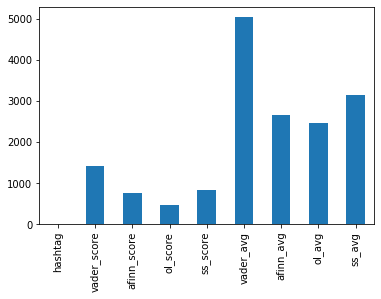

In [16]:
#check null values and select dictionary score with the least amout of null values
sent_df.isnull().sum().plot(kind='bar')

The sentiment dictionary showing the least amount of null values in the score column is the Opinion Lexicon (ol) dictionary.  We will keep the 'hashtag' and 'ol_score' columns and drop the remaining columns.

In [17]:
#Keep only hashtag and ol_score columns
sent_df = sent_df[['hashtag','ol_score']]
sent_df.head()

,hashtag,ol_score
0,relaxtime,2.4
1,melovechilicheese,0.8
2,greatmusic,2.4
3,rockballad,0.7
4,amonamarth,0.3


In [18]:
#check null values
sent_df.isnull().sum()

hashtag       0
ol_score    459
dtype: int64

In [19]:
#Drop all rows with null values
sent_df = sent_df.dropna(axis = 0)

In [20]:
#verify dropped nulls
sent_df.isnull().sum()

hashtag     0
ol_score    0
dtype: int64

In [28]:
print(f" Subsequent to dropping null values the dataset was reduced by {5290 - sent_df.shape[0]} rows")
print(sent_df.shape)

 Subsequent to dropping null values the dataset was reduced by 459 rows
(4831, 2)


In [22]:
#Save hashtag sentiment df for future use
sent_df.to_csv('ht_olscore.csv')

Subsequent to cleaning the data we are left with a sentiment dataframe with 4831 unique hashtags and associated scores derived from the Opinion Lexicon dictionary.

#### context/content data file

In [22]:
#load data into pandas
con_df = pd.read_csv('C:\\Users\\pseudo_bounce\\Desktop\\nowplayingrs\\nowplaying_rs_dataset\\context_content_features.csv')

In [23]:
#print shape
con_df.shape

(11614671, 23)

We can reduce this file by dropping some of the columns we dont need and restricting the language to only English.  First we will drop irrelevant columns, then filter language column to English.  Finally we will drop any null values.

In [24]:
#look at null values
con_df.isnull().sum()

coordinates         11576613
instrumentalness        2802
liveness                2914
speechiness             3888
danceability            3888
valence                 4788
loudness                   0
tempo                      0
acousticness            2787
energy                  2761
mode                    2714
key                     2714
artist_id                  0
place               11570327
geo                 11576613
tweet_lang                 0
track_id                   0
created_at                 0
lang                       0
time_zone            3260355
entities            11614671
user_id                    0
id                         0
dtype: int64

In [25]:
#drop the following columns
con_df = con_df.drop(['coordinates','id','place','geo','entities','time_zone'], axis=1)

In [26]:
#check head
con_df.head()

,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy,mode,key,artist_id,tweet_lang,track_id,created_at,lang,user_id
0,0.004790,0.1800,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697,1.0,6.0,b2980c722a1ace7a30303718ce5491d8,en,cd52b3e5b51da29e5893dba82a418a4b,2014-01-01 05:54:21,en,81496937
1,0.017700,0.0638,0.0624,0.769,0.752,-8.252,95.862,0.26700,0.826,1.0,7.0,5cddcd0e314e2f2223ab21937d2c8778,en,da3110a77b724072b08f231c9d6f7534,2014-01-01 05:54:22,en,2205686924
2,0.000000,0.0860,0.0436,0.675,0.775,-4.432,97.030,0.21700,0.885,0.0,1.0,e41273f43af504714d85465294f1f369,en,ba84d88c10fb0e42d4754a27ead10546,2014-01-01 05:54:22,es,132588395
3,0.000000,0.1430,0.0292,0.324,0.333,-5.647,74.101,0.23900,0.574,1.0,7.0,557ce373bd29743eb00a3723ab19ebe8,en,33f95122281f76e7134f9cbea3be980f,2014-01-01 05:54:24,en,97675221
4,0.000183,0.3620,0.0524,0.767,0.808,-5.011,114.237,0.03640,0.739,0.0,10.0,77bd64b4bf77e10001fd02964985ae0f,en,b5c42e81e15cd54b9b0ee34711dedf05,2014-01-01 05:54:24,en,17945688


In [27]:
#Limit dataset to only en (English) language
con_df = con_df[con_df['lang'] == 'en']

In [29]:
#new shape after filtering
con_df.shape

(8812669, 17)

In [30]:
#now that we know only value for the lang column us 'en,' we can drop the 'tweet_lang' and 'lang' columns
con_df = con_df.drop(['tweet_lang','lang'], axis=1)

In [29]:
#shape
con_df.shape

(8812669, 17)

In [32]:
#print head
con_df.head()

,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy,mode,key,artist_id,track_id,created_at,user_id
0,0.004790,0.1800,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697,1.0,6.0,b2980c722a1ace7a30303718ce5491d8,cd52b3e5b51da29e5893dba82a418a4b,2014-01-01 05:54:21,81496937
1,0.017700,0.0638,0.0624,0.769,0.752,-8.252,95.862,0.26700,0.826,1.0,7.0,5cddcd0e314e2f2223ab21937d2c8778,da3110a77b724072b08f231c9d6f7534,2014-01-01 05:54:22,2205686924
3,0.000000,0.1430,0.0292,0.324,0.333,-5.647,74.101,0.23900,0.574,1.0,7.0,557ce373bd29743eb00a3723ab19ebe8,33f95122281f76e7134f9cbea3be980f,2014-01-01 05:54:24,97675221
4,0.000183,0.3620,0.0524,0.767,0.808,-5.011,114.237,0.03640,0.739,0.0,10.0,77bd64b4bf77e10001fd02964985ae0f,b5c42e81e15cd54b9b0ee34711dedf05,2014-01-01 05:54:24,17945688
5,0.000000,0.1100,0.0375,0.641,0.912,-4.271,93.010,0.02680,0.787,1.0,0.0,f965ec352eb8c0efc0af46244754942f,8bd5206b84c968eda0af8bc86d6ab1d1,2014-01-01 05:54:25,452285741


#### Combining the 3 files 

In [30]:
#Merge CSV files into a single file based on hashtag
temp_df = pd.merge(utdf, sent_df, on="hashtag", how='inner')

In [32]:
#check shape
print(temp_df.shape)

#validate join
temp_df.head()

(6053259, 5)


,user_id,track_id,hashtag,created_at,ol_score
0,81496937,cd52b3e5b51da29e5893dba82a418a4b,nowplaying,2014-01-01 05:54:21,0.6
1,132588395,ba84d88c10fb0e42d4754a27ead10546,nowplaying,2014-01-01 05:54:22,0.6
2,97675221,33f95122281f76e7134f9cbea3be980f,nowplaying,2014-01-01 05:54:24,0.6
3,17945688,b5c42e81e15cd54b9b0ee34711dedf05,nowplaying,2014-01-01 05:54:24,0.6
4,452285741,8bd5206b84c968eda0af8bc86d6ab1d1,nowplaying,2014-01-01 05:54:25,0.6


In [33]:
#Merge df_sentiment and df3 CSV files into new CSV file based on track_id, created_at and user_id
df = temp_df.merge(con_df, on=['track_id','created_at','user_id'], how='inner')

In [48]:
#precautionary measure
df.to_csv('updated_merge.csv')

In [34]:
#verify join
df.head()

,user_id,track_id,hashtag,created_at,ol_score,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy,mode,key,artist_id,tweet_lang,lang
0,81496937,cd52b3e5b51da29e5893dba82a418a4b,nowplaying,2014-01-01 05:54:21,0.6,0.004790,0.180,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697,1.0,6.0,b2980c722a1ace7a30303718ce5491d8,en,en
1,81496937,cd52b3e5b51da29e5893dba82a418a4b,deathrock,2014-01-01 05:54:21,1.3,0.004790,0.180,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697,1.0,6.0,b2980c722a1ace7a30303718ce5491d8,en,en
2,81496937,cd52b3e5b51da29e5893dba82a418a4b,postpunk,2014-01-01 05:54:21,0.0,0.004790,0.180,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697,1.0,6.0,b2980c722a1ace7a30303718ce5491d8,en,en
3,97675221,33f95122281f76e7134f9cbea3be980f,nowplaying,2014-01-01 05:54:24,0.6,0.000000,0.143,0.0292,0.324,0.333,-5.647,74.101,0.23900,0.574,1.0,7.0,557ce373bd29743eb00a3723ab19ebe8,en,en
4,17945688,b5c42e81e15cd54b9b0ee34711dedf05,nowplaying,2014-01-01 05:54:24,0.6,0.000183,0.362,0.0524,0.767,0.808,-5.011,114.237,0.03640,0.739,0.0,10.0,77bd64b4bf77e10001fd02964985ae0f,en,en


In [37]:
#check shape
df.shape

(5143288, 17)

After the joins we are now able to preserve the hashtags and drop the duplicate rows.  The shape of the dataframe suggests roughly 5 million listening events (LE's).  However, careful inspection of the dataset, specifically the 'created_at' field reveals a 'one to many' relationship between the user_id, track_id, and the hashtag column.  The timestamps are exact to the second indicating a single LE.  This is due to multiple hashtags being applied to a unique LE.  The goal of the next few steps is to remove the duplicate columns, while retaining all the hashtags associated with the event.  This is achieved by creating a dictionary from a group by on the user_id, track_id columns and selecting the hashtag, and mapping the dictionary values to the dataframe on the user_id and track_id.  Next, an lamba/apply method will be used to ensure unique hashtags per event if mulitple exist.

In [35]:
#create dictionary to store list of hashtags from each user/track
utd = df.groupby(['user_id','track_id'])['hashtag'].apply(list).to_dict()

In [36]:
#map dictionary to dataframe matching the user_id and track_id to the dictionary keys
df['htag'] = df.set_index(['user_id','track_id']).index.map(utd.get)

In [37]:
#verify operations
df.head()

,user_id,track_id,hashtag,created_at,ol_score,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy,mode,key,artist_id,tweet_lang,lang,htag
0,81496937,cd52b3e5b51da29e5893dba82a418a4b,nowplaying,2014-01-01 05:54:21,0.6,0.004790,0.180,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697,1.0,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ..."
1,81496937,cd52b3e5b51da29e5893dba82a418a4b,deathrock,2014-01-01 05:54:21,1.3,0.004790,0.180,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697,1.0,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ..."
2,81496937,cd52b3e5b51da29e5893dba82a418a4b,postpunk,2014-01-01 05:54:21,0.0,0.004790,0.180,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697,1.0,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ..."
3,97675221,33f95122281f76e7134f9cbea3be980f,nowplaying,2014-01-01 05:54:24,0.6,0.000000,0.143,0.0292,0.324,0.333,-5.647,74.101,0.23900,0.574,1.0,7.0,557ce373bd29743eb00a3723ab19ebe8,en,en,"[nowplaying, nowplaying, nowplaying, nowplayin..."
4,17945688,b5c42e81e15cd54b9b0ee34711dedf05,nowplaying,2014-01-01 05:54:24,0.6,0.000183,0.362,0.0524,0.767,0.808,-5.011,114.237,0.03640,0.739,0.0,10.0,77bd64b4bf77e10001fd02964985ae0f,en,en,[nowplaying]


We can see that we that the hashtags have been stored in a list and applied to the corresponding LE's.  We can now drop the duplicate rows, having preserved the hashtags

In [38]:
#check shape
df.shape

(5143288, 20)

In [39]:
#drop duplicates rows based on the 'created_at' column
df1 = df.drop_duplicates(subset='created_at')

In [40]:
#verify shape
df1.shape

(4439589, 20)

In [41]:
df1.head()

,user_id,track_id,hashtag,created_at,ol_score,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy,mode,key,artist_id,tweet_lang,lang,htag
0,81496937,cd52b3e5b51da29e5893dba82a418a4b,nowplaying,2014-01-01 05:54:21,0.6,0.004790,0.180,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697,1.0,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ..."
3,97675221,33f95122281f76e7134f9cbea3be980f,nowplaying,2014-01-01 05:54:24,0.6,0.000000,0.143,0.0292,0.324,0.333,-5.647,74.101,0.23900,0.574,1.0,7.0,557ce373bd29743eb00a3723ab19ebe8,en,en,"[nowplaying, nowplaying, nowplaying, nowplayin..."
5,452285741,8bd5206b84c968eda0af8bc86d6ab1d1,nowplaying,2014-01-01 05:54:25,0.6,0.000000,0.110,0.0375,0.641,0.912,-4.271,93.010,0.02680,0.787,1.0,0.0,f965ec352eb8c0efc0af46244754942f,en,en,"[nowplaying, nowplaying, nowplaying, nowplayin..."
6,65086276,23ced06ca57d37fa749b1595bc7ed1a4,nowplaying,2014-01-01 05:54:28,0.6,0.000006,0.362,0.1340,0.554,0.677,-4.271,126.045,0.02160,0.878,1.0,3.0,a3abd1e016fdba82a91379b7e2b9ab69,en,en,"[nowplaying, nowplaying, nowplaying, nowplayin..."
7,585098987,6b2590cf3b9cd3386cd4ba4b012eaf3b,nowplaying,2014-01-01 05:54:31,0.6,0.049900,0.188,0.0295,0.817,0.909,-8.392,111.416,0.48600,0.845,1.0,0.0,a9ab7331dca645a72dca6b1bfac805d2,en,en,"[nowplaying, nowplaying]"


In [42]:
#compare shape with initial set
print(f"Initial shape is: {df.shape}")
print(f"New shape is: {df1.shape}")
print(f"{round(1 - (df1.shape[0]/df.shape[0]),3)}% of the listening events were multiples of a single event")

Initial shape is: (5143288, 20)
New shape is: (4439589, 20)
0.137% of the listening events were multiples of a single event


In [43]:
df1 = df1.reset_index()

In [44]:
df1.head()

,index,user_id,track_id,hashtag,created_at,ol_score,instrumentalness,liveness,speechiness,danceability,...,loudness,tempo,acousticness,energy,mode,key,artist_id,tweet_lang,lang,htag
0,0,81496937,cd52b3e5b51da29e5893dba82a418a4b,nowplaying,2014-01-01 05:54:21,0.6,0.004790,0.180,0.0294,0.634,...,-8.345,125.044,0.00035,0.697,1.0,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ..."
1,3,97675221,33f95122281f76e7134f9cbea3be980f,nowplaying,2014-01-01 05:54:24,0.6,0.000000,0.143,0.0292,0.324,...,-5.647,74.101,0.23900,0.574,1.0,7.0,557ce373bd29743eb00a3723ab19ebe8,en,en,"[nowplaying, nowplaying, nowplaying, nowplayin..."
2,5,452285741,8bd5206b84c968eda0af8bc86d6ab1d1,nowplaying,2014-01-01 05:54:25,0.6,0.000000,0.110,0.0375,0.641,...,-4.271,93.010,0.02680,0.787,1.0,0.0,f965ec352eb8c0efc0af46244754942f,en,en,"[nowplaying, nowplaying, nowplaying, nowplayin..."
3,6,65086276,23ced06ca57d37fa749b1595bc7ed1a4,nowplaying,2014-01-01 05:54:28,0.6,0.000006,0.362,0.1340,0.554,...,-4.271,126.045,0.02160,0.878,1.0,3.0,a3abd1e016fdba82a91379b7e2b9ab69,en,en,"[nowplaying, nowplaying, nowplaying, nowplayin..."
4,7,585098987,6b2590cf3b9cd3386cd4ba4b012eaf3b,nowplaying,2014-01-01 05:54:31,0.6,0.049900,0.188,0.0295,0.817,...,-8.392,111.416,0.48600,0.845,1.0,0.0,a9ab7331dca645a72dca6b1bfac805d2,en,en,"[nowplaying, nowplaying]"


In [45]:
df1 = df1.drop(['index','hashtag'],axis=1)

In [46]:
df1.head()

,user_id,track_id,created_at,ol_score,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy,mode,key,artist_id,tweet_lang,lang,htag
0,81496937,cd52b3e5b51da29e5893dba82a418a4b,2014-01-01 05:54:21,0.6,0.004790,0.180,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697,1.0,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ..."
1,97675221,33f95122281f76e7134f9cbea3be980f,2014-01-01 05:54:24,0.6,0.000000,0.143,0.0292,0.324,0.333,-5.647,74.101,0.23900,0.574,1.0,7.0,557ce373bd29743eb00a3723ab19ebe8,en,en,"[nowplaying, nowplaying, nowplaying, nowplayin..."
2,452285741,8bd5206b84c968eda0af8bc86d6ab1d1,2014-01-01 05:54:25,0.6,0.000000,0.110,0.0375,0.641,0.912,-4.271,93.010,0.02680,0.787,1.0,0.0,f965ec352eb8c0efc0af46244754942f,en,en,"[nowplaying, nowplaying, nowplaying, nowplayin..."
3,65086276,23ced06ca57d37fa749b1595bc7ed1a4,2014-01-01 05:54:28,0.6,0.000006,0.362,0.1340,0.554,0.677,-4.271,126.045,0.02160,0.878,1.0,3.0,a3abd1e016fdba82a91379b7e2b9ab69,en,en,"[nowplaying, nowplaying, nowplaying, nowplayin..."
4,585098987,6b2590cf3b9cd3386cd4ba4b012eaf3b,2014-01-01 05:54:31,0.6,0.049900,0.188,0.0295,0.817,0.909,-8.392,111.416,0.48600,0.845,1.0,0.0,a9ab7331dca645a72dca6b1bfac805d2,en,en,"[nowplaying, nowplaying]"


In [47]:
#ensure hashtags are unique per LE
df1['tag'] = df1['htag'].apply(lambda x: set(x))

In [48]:
df1.head()

,user_id,track_id,created_at,ol_score,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy,mode,key,artist_id,tweet_lang,lang,htag,tag
0,81496937,cd52b3e5b51da29e5893dba82a418a4b,2014-01-01 05:54:21,0.6,0.004790,0.180,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697,1.0,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ...","{postpunk, deathrock, nowplaying}"
1,97675221,33f95122281f76e7134f9cbea3be980f,2014-01-01 05:54:24,0.6,0.000000,0.143,0.0292,0.324,0.333,-5.647,74.101,0.23900,0.574,1.0,7.0,557ce373bd29743eb00a3723ab19ebe8,en,en,"[nowplaying, nowplaying, nowplaying, nowplayin...",{nowplaying}
2,452285741,8bd5206b84c968eda0af8bc86d6ab1d1,2014-01-01 05:54:25,0.6,0.000000,0.110,0.0375,0.641,0.912,-4.271,93.010,0.02680,0.787,1.0,0.0,f965ec352eb8c0efc0af46244754942f,en,en,"[nowplaying, nowplaying, nowplaying, nowplayin...",{nowplaying}
3,65086276,23ced06ca57d37fa749b1595bc7ed1a4,2014-01-01 05:54:28,0.6,0.000006,0.362,0.1340,0.554,0.677,-4.271,126.045,0.02160,0.878,1.0,3.0,a3abd1e016fdba82a91379b7e2b9ab69,en,en,"[nowplaying, nowplaying, nowplaying, nowplayin...",{nowplaying}
4,585098987,6b2590cf3b9cd3386cd4ba4b012eaf3b,2014-01-01 05:54:31,0.6,0.049900,0.188,0.0295,0.817,0.909,-8.392,111.416,0.48600,0.845,1.0,0.0,a9ab7331dca645a72dca6b1bfac805d2,en,en,"[nowplaying, nowplaying]",{nowplaying}


In [49]:
#check shape
df1.shape

(4439589, 20)

Next, we want to filter users and tracks to ensure users and tracks aren't too rare, and reduce sparsity of the user/item matrix. Temporary dataframes are built to store value counts of each user and track.

In [69]:
#create temporary dataframe to store track counts
tc = df1['track_id'].value_counts().to_frame()
tc.columns = ['count']
tc.head()

,count
3d02f9fcad37e6bb227682761039498c,9572
7188f922ba73eb2509c02d15ec62ff0e,9449
5758909ef03fc3a2efaa57408ad43f22,6147
d6b1124fdd64c4b1afa59f967397111d,6143
acca7456f99b4699871d3fe249e5fe11,4994


In [70]:
t10 = tc[tc['count'] >= 10]

In [81]:
#reset index and label column
t10 = tc.reset_index().rename(columns={'index':'track_id'})

In [82]:
t10 = t10[t10['count'] >= 10]

In [83]:
t10.head()

,track_id,count
0,3d02f9fcad37e6bb227682761039498c,9572
1,7188f922ba73eb2509c02d15ec62ff0e,9449
2,5758909ef03fc3a2efaa57408ad43f22,6147
3,d6b1124fdd64c4b1afa59f967397111d,6143
4,acca7456f99b4699871d3fe249e5fe11,4994


In [54]:
t10.tail()

,track_id,count
52690,34380fef67add82bdc91f4d975a4c328,10
52691,5a973cec5ade71a739bc6b93711bb4dd,10
52692,28d345f87e922df0859996858aea216b,10
52693,c9220f312e2b46c494861837afc57015,10
52694,786a866d4075a63dd51eea82fdbcc157,10


In [55]:
#use join to filter df1 where track count >= 10
tfilter = pd.merge(df1,t10,on='track_id',how='right')

In [67]:
t10.head()

,track_id,count
0,3d02f9fcad37e6bb227682761039498c,9572
1,7188f922ba73eb2509c02d15ec62ff0e,9449
2,5758909ef03fc3a2efaa57408ad43f22,6147
3,d6b1124fdd64c4b1afa59f967397111d,6143
4,acca7456f99b4699871d3fe249e5fe11,4994


In [78]:
#check shape of filtered dataframe
print(df1.shape)
print(tfilter.shape)


(4439589, 20)
(4068079, 24)


In [79]:
tfilter.head()

,user_id,track_id,created_at,ol_score,instrumentalness,liveness,speechiness,danceability,valence,loudness,...,key,artist_id,tweet_lang,lang,htag,tag,count,uid_code,tid_code,aid_code
0,81496937,cd52b3e5b51da29e5893dba82a418a4b,2014-01-01 05:54:21,0.6,0.00479,0.18,0.0294,0.634,0.342,-8.345,...,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ...","{postpunk, deathrock, nowplaying}",28,4121,42353,8489
1,81496937,cd52b3e5b51da29e5893dba82a418a4b,2014-02-19 11:21:51,0.6,0.00479,0.18,0.0294,0.634,0.342,-8.345,...,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ...","{postpunk, deathrock, nowplaying}",28,4121,42353,8489
2,81496937,cd52b3e5b51da29e5893dba82a418a4b,2014-03-02 15:28:20,0.6,0.00479,0.18,0.0294,0.634,0.342,-8.345,...,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ...","{postpunk, deathrock, nowplaying}",28,4121,42353,8489
3,81496937,cd52b3e5b51da29e5893dba82a418a4b,2014-03-04 01:32:31,0.6,0.00479,0.18,0.0294,0.634,0.342,-8.345,...,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ...","{postpunk, deathrock, nowplaying}",28,4121,42353,8489
4,81496937,cd52b3e5b51da29e5893dba82a418a4b,2014-04-07 20:20:46,0.6,0.00479,0.18,0.0294,0.634,0.342,-8.345,...,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ...","{postpunk, deathrock, nowplaying}",28,4121,42353,8489


In [80]:
#verify all songs have at least 10 occurances
tfilter.track_id.value_counts()

3d02f9fcad37e6bb227682761039498c    9572
7188f922ba73eb2509c02d15ec62ff0e    9449
5758909ef03fc3a2efaa57408ad43f22    6147
d6b1124fdd64c4b1afa59f967397111d    6143
acca7456f99b4699871d3fe249e5fe11    4994
                                    ... 
a5e44995e7e4cf143fc0df0c9538333d      10
7d04a2d005676d4c2a6e09728b2fc4f9      10
56fbf3ad950b7608d4428afd5d98ffe9      10
58df958a30252d350e41f4422965cb65      10
8d5880ea66a8711da4fec1ea80096181      10
Name: track_id, Length: 52695, dtype: int64

In [62]:
#created codes for user_id,track_id, artist_id to be numeric and sequential
tfilter['uid_code'] = tfilter['user_id'].astype('category').cat.codes
tfilter['tid_code'] = tfilter['track_id'].astype('category').cat.codes
tfilter['aid_code'] = tfilter['artist_id'].astype('category').cat.codes

In [63]:
tfilter.head()

,user_id,track_id,created_at,ol_score,instrumentalness,liveness,speechiness,danceability,valence,loudness,...,key,artist_id,tweet_lang,lang,htag,tag,count,uid_code,tid_code,aid_code
0,81496937,cd52b3e5b51da29e5893dba82a418a4b,2014-01-01 05:54:21,0.6,0.00479,0.18,0.0294,0.634,0.342,-8.345,...,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ...","{postpunk, deathrock, nowplaying}",28,4121,42353,8489
1,81496937,cd52b3e5b51da29e5893dba82a418a4b,2014-02-19 11:21:51,0.6,0.00479,0.18,0.0294,0.634,0.342,-8.345,...,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ...","{postpunk, deathrock, nowplaying}",28,4121,42353,8489
2,81496937,cd52b3e5b51da29e5893dba82a418a4b,2014-03-02 15:28:20,0.6,0.00479,0.18,0.0294,0.634,0.342,-8.345,...,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ...","{postpunk, deathrock, nowplaying}",28,4121,42353,8489
3,81496937,cd52b3e5b51da29e5893dba82a418a4b,2014-03-04 01:32:31,0.6,0.00479,0.18,0.0294,0.634,0.342,-8.345,...,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ...","{postpunk, deathrock, nowplaying}",28,4121,42353,8489
4,81496937,cd52b3e5b51da29e5893dba82a418a4b,2014-04-07 20:20:46,0.6,0.00479,0.18,0.0294,0.634,0.342,-8.345,...,6.0,b2980c722a1ace7a30303718ce5491d8,en,en,"[nowplaying, deathrock, postpunk, nowplaying, ...","{postpunk, deathrock, nowplaying}",28,4121,42353,8489


In [84]:
tfilter.to_csv('NPRS_FINAL.csv')